In [83]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [84]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [85]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [86]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [87]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [88]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

In [89]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
1,-0.49,101.00,2.015176,33.39,0.0
2,-0.49,101.00,2.015176,33.39,0.0
3,-0.49,101.00,2.015176,33.39,0.0
4,-0.49,101.00,2.015176,33.39,0.0
...,...,...,...,...,...
4143995,-6.21,73.65,0.783331,31.81,0.0
4143996,-6.21,73.65,0.783331,31.81,0.0
4143997,-6.21,73.65,0.783331,31.81,0.0
4143998,-6.21,73.65,0.783331,31.81,0.0


In [90]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [91]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
6,-0.38,101.00,2.015176,33.39,0.0
17,-0.36,101.00,2.015176,33.39,0.0
20,-0.36,106.50,2.015176,33.39,0.0
28,-0.75,106.50,2.015176,33.39,0.0
...,...,...,...,...,...
4143942,-2.09,73.65,0.783331,31.81,0.0
4143951,-3.28,73.65,0.783331,31.81,0.0
4143962,-4.43,73.65,0.783331,31.81,0.0
4143973,-5.44,73.65,0.783331,31.81,0.0


In [92]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## NORMALIZAR E CRIAR MIN, MEAN, MAX


Temperatura

In [93]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [94]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [95]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.002561,0.002561,0.002561
1,0.002561,0.002561,0.002561
2,0.002561,0.002561,0.002561
3,0.002561,0.002561,0.002559
4,0.002559,0.002559,0.002559



EDA

In [96]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [97]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  2.015176  2.015176  2.015176
1  2.015176  2.015176  2.015176
2  2.015176  2.015176  2.015176
3  2.012617  2.015176  2.014323
4  2.012617  2.012617  2.012617


In [98]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [99]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.004543,0.004542,0.004544
1,0.004543,0.004542,0.004544
2,0.004543,0.004542,0.004544
3,0.004541,0.004542,0.004539
4,0.004537,0.004536,0.004539


HR


In [100]:
hr_min = []
hr_max = []
hr_mean = []
for i in range(0, len(df), 3):
    hr = df['hr'].iloc[i:i+3]
    hr_min.append(hr.min())
    hr_max.append(hr.max())
    hr_mean.append(hr.mean())

hr_stats = pd.DataFrame({'hr_min': hr_min, 'hr_max': hr_max, 'hr_mean': hr_mean})

hr_min_array = np.array(hr_stats['hr_min'])
normalized_hr_min = preprocessing.normalize([hr_min_array])
hr_max_array = np.array(hr_stats['hr_max'])
normalized_hr_max = preprocessing.normalize([hr_max_array])
hr_mean_array = np.array(hr_stats['hr_mean'])
normalized_hr_mean = preprocessing.normalize([hr_mean_array])

In [101]:
data_hr = {
    'normalized_hr_mean': normalized_hr_mean.flatten(),
    'normalized_hr_max': normalized_hr_max.flatten(),
    'normalized_hr_min': normalized_hr_min.flatten()
}

df_hr = pd.DataFrame(data_hr)
df_hr.head()

,normalized_hr_mean,normalized_hr_max,normalized_hr_min
0,0.003260,0.003259,0.003262
1,0.003438,0.003436,0.003440
2,0.003198,0.003436,0.003079
3,0.003077,0.003076,0.003079
4,0.002968,0.003076,0.002915


In [102]:
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [103]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

Random Forest

In [104]:
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)


#### knn

In [105]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [106]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")

k_nearest_neighbors.fit(X_train, y_train.ravel())

y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score   = f1_score        (y_test, y_pred_knn, average = 'macro')
recall    = recall_score    (y_test, y_pred_knn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_knn)
AUC       = roc_auc_score   (y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.991591047189687
acc = 0.9490067753235584
f1 = 0.9442958738494482
recall = 0.9461815087771754


#### Logistic Regression

In [107]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)

logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score   = f1_score        (y_test, y_pred_lr, average = 'macro')
recall    = recall_score    (y_test, y_pred_lr, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_lr)
AUC       = roc_auc_score   (y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.7752635523657919
acc = 0.47582489039917775
f1 = 0.12896513495458875
recall = 0.2


#### RF

In [108]:

#clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9995656119693294
acc = 0.9834497514316279
f1 = 0.9821722274532121
recall = 0.9833897127553867


#### neural network

#### SVM

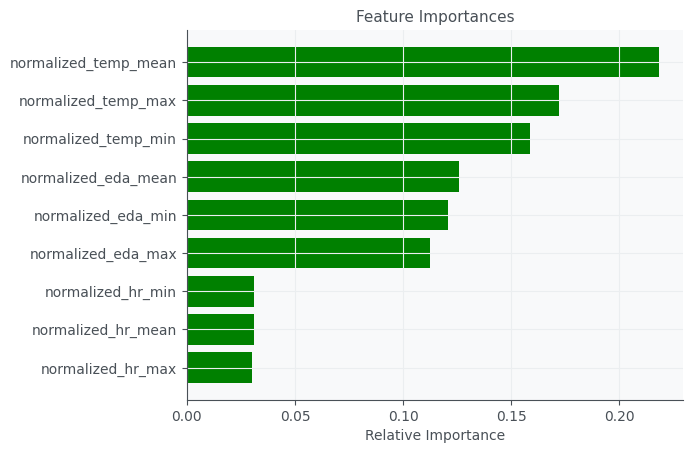

In [109]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

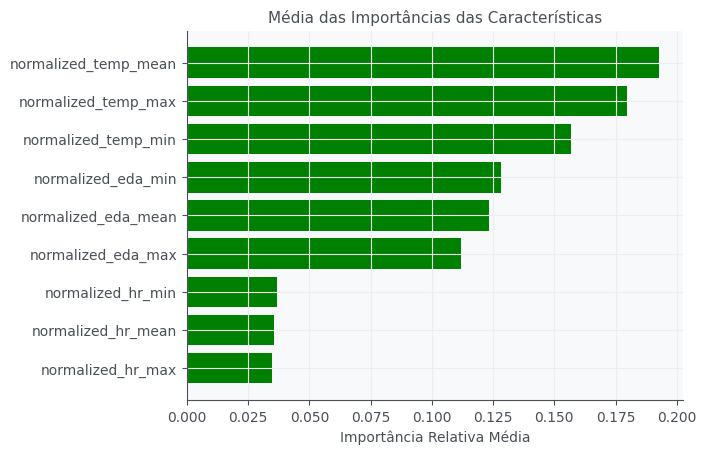

In [110]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()

# Criação de datasets individuais

In [111]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    # Processar os dados de frequência cardíaca (HR)
    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            # Adicionar os dados ao dataframe específico do usuário
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

# Processar cada dataframe de usuário para calcular e normalizar as estatísticas
for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    # Filtrar os dados com base nos rótulos desejados
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    # Função para calcular estatísticas e normalizar
    def calculate_and_normalize_stats(df, column):
        min_vals, max_vals, mean_vals = [], [], []
        for i in range(0, len(df), 3):
            vals = df[column].iloc[i:i+3]
            min_vals.append(vals.min())
            max_vals.append(vals.max())
            mean_vals.append(vals.mean())
        stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
        normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
        normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
        normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
        return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                            f'normalized_{column}_max': normalized_max,
                            f'normalized_{column}_min': normalized_min})

    # Calcular e normalizar estatísticas para temperatura, EDA e HR
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    # Combinar os dataframes normalizados
    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    # Calcular a média dos labels para cada janela de 3 amostras
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})
    
    # Armazenar o dataframe normalizado no dicionário
    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

# Criar variáveis individuais dfs2 a dfs17
for i in range(2, 11):
    globals()[f'dfs{i}'] = dfs[f'S{i}']
for i in range(13, 18):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

### aplicando series temporais

In [143]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn import metrics

In [144]:
X = dfs2.drop(columns=["label_mean"]) 
y = dfs2["label_mean"].astype(int)
X_train_skt, X_test_skt, y_train_skt, y_test_skt = temporal_train_test_split(X, y, test_size=0.3)
X_train_array = X_train_skt.values
X_test_array = X_test_skt.values
print("X_train_array shape:", X_train_array.shape)
print("X_test_array shape:", X_test_array.shape)

X_train_array shape: (5559, 9)
X_test_array shape: (2383, 9)


In [145]:

tsf = TimeSeriesForestClassifier(n_estimators=50, random_state=47)
tsf.fit(X_train_array, y_train_skt)

tsf_preds = tsf.predict(X_test_array)
print("TSF Accuracy: " + str(metrics.accuracy_score(y_test_skt, tsf_preds)))

TSF Accuracy: 0.44020142677297525


### usar rf nos datasets individuais

In [118]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)
    


 Dataset: dfs2
auc = 0.5192952038868429
acc = 0.19302442709644926
f1 = 0.07115387085675415
recall = 0.202940787466329

 Dataset: dfs3
auc = 0.4455703412455555
acc = 0.18957816377171216
f1 = 0.06490276911067047
recall = 0.1971965065555032

 Dataset: dfs4
auc = 0.48606031405261757
acc = 0.16305189775367931
f1 = 0.05845468874926187
recall = 0.20181731229076996

 Dataset: dfs5
auc = 0.5849043857257143
acc = 0.18567137612637669
f1 = 0.06687239679614397
recall = 0.19810087061839962

 Dataset: dfs6
auc = 0.5589331236759991
acc = 0.14937955858671972
f1 = 0.05569066794373484
recall = 0.20120458896724341

 Dataset: dfs7
auc = 0.5
acc = 0.22881146528292562
f1 = 0.07448220390106576
recall = 0.2

 Dataset: dfs8
auc = 0.5
acc = 0.20211515863689777
f1 = 0.06725317693059628
recall = 0.2

 Dataset: dfs9
auc = 0.5675915952702193
acc = 0.2063867534003548
f1 = 0.06853339067679855
recall = 0.19354951210244312

 Dataset: dfs10
auc = 0.5933442905569406
acc = 0.21028165162701667
f1 = 0.07026998356758143
reca

In [119]:
for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs13
auc = 0.5117733521170604
acc = 0.21030434287016983
f1 = 0.07784221611420769
recall = 0.18907967983972515

 Dataset: dfs14
auc = 0.5
acc = 0.21663019693654267
f1 = 0.07122302158273382
recall = 0.2

 Dataset: dfs15
auc = 0.5530733164458725
acc = 0.19655172413793104
f1 = 0.0662003397727228
recall = 0.18292845169969865

 Dataset: dfs16
auc = 0.6250181058013604
acc = 0.21334954735846506
f1 = 0.07953735649979554
recall = 0.20644412191582004

 Dataset: dfs17
auc = 0.5
acc = 0.202686495562485
f1 = 0.06741124850418827
recall = 0.2


### testando o knn para ver ser as metricas diminuem tanto

In [120]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.5192952038868429
acc = 0.2280282044824981
f1 = 0.1449718932271763
recall = 0.2070540163914119

 Dataset: dfs3
auc = 0.4455703412455555
acc = 0.2294044665012407
f1 = 0.16367826874512809
recall = 0.29219239480545883

 Dataset: dfs4
auc = 0.48606031405261757
acc = 0.14304156984249936
f1 = 0.07143776494404405
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5849043857257143
acc = 0.3143842474135054
f1 = 0.1529238440169418
recall = 0.2290396817197426

 Dataset: dfs6
auc = 0.5589331236759991
acc = 0.18044899119067917
f1 = 0.10468375280747391
recall = 0.13200486606997303

 Dataset: dfs7
auc = 0.5
acc = 0.41018038052878675
f1 = 0.20274804493900406
recall = 0.28607564020281717

 Dataset: dfs8
auc = 0.5
acc = 0.27893654524089306
f1 = 0.12926545120835703
recall = 0.23048861308591398

 Dataset: dfs9
auc = 0.5675915952702193
acc = 0.2440863394441159
f1 = 0.12930855789883142
recall = 0.15859781918948576

 Dataset: dfs10
auc = 0.5933442905569406
acc = 0.09133169264424391
f

In [121]:
for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs13
auc = 0.5117733521170604
acc = 0.3230365895360766
f1 = 0.15246574027259122
recall = 0.24473554540616088

 Dataset: dfs14
auc = 0.5
acc = 0.3927789934354486
f1 = 0.1882707832977201
recall = 0.27406394774815823

 Dataset: dfs15
auc = 0.5530733164458725
acc = 0.23505747126436782
f1 = 0.12508262920238827
recall = 0.16589757346749096

 Dataset: dfs16
auc = 0.6250181058013604
acc = 0.10728279962167275
f1 = 0.05981843478875737
recall = 0.04672126803842397

 Dataset: dfs17
auc = 0.5
acc = 0.13756296473974575
f1 = 0.0652499742629383
recall = 0.1048257725180802


#### Treinando e testando RF no s2 para comparacao com as metricas do s2 rodado com rf do dataset conjunto

In [122]:
train_set = dfs2.drop(columns=["label_mean"])
labels = dfs2["label_mean"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [123]:
clfind = RandomForestClassifier(n_estimators=100,max_depth=15)
clfind.fit(X_train, y_train.ravel())
y_pred_rf = clfind.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clfind.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9991632516965762
acc = 0.9798573227024758
f1 = 0.9731174594488049
recall = 0.9748704039645009
